In [ ]:
!pip install -q -U pytorch_lightning wandb monai

In [ ]:
from functools import lru_cache
import os

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set()

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from sklearn.model_selection import train_test_split

from monai.losses import TverskyLoss
from monai.losses.dice import DiceLoss

import pytorch_lightning as pl
import albumentations as A
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Данные

In [ ]:
class CityScapesDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory,  transform=None):
        '''Задаем аугментации и пути к картинкам и маскам'''
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    @lru_cache(maxsize=100)
    def _get_image_mask(self, image_filename):
        '''Получим картинку и маску для файла image_filename'''
        # Считываем изображение
        image = np.array(Image.open(os.path.join(self.images_directory, image_filename)))

        # Считываем маску
        splitted = image_filename.split('.')
        mask_filename = splitted[0] + "_mask" + ".png"

        mask = np.array(Image.open(os.path.join(self.masks_directory, mask_filename))).clip(0, 1)

        return image, mask

    def __getitem__(self, idx):
        '''Получим картинку и маску индекса idx'''
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию), если это необходимо
        if self.transform is not None:
            try:
                transformed = self.transform(image=image, mask=mask)
            except:
                print(image_filename)
                raise ValueError
            image = transformed["image"]
            mask = transformed["mask"]

        return np.moveaxis(image.astype(np.float32), 2, 0), mask.astype(np.float32)[None]

Запишем пути до изображений и масок.

In [ ]:
!unzip "/content/drive/MyDrive/DS/cityscapes.zip" -d '/content'
data_path = '/content/cityscapes'
images_directory = os.path.join(data_path, "images")
masks_directory = os.path.join(data_path, "masks")
filenames = list(sorted(os.listdir(images_directory)))
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)

Определим датасет.

In [ ]:
size = (160, 240)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = A.Compose([
    A.Resize(*size),
    A.Normalize(mean, std),
])
train_set = CityScapesDataset(train_filenames, images_directory, masks_directory, transform=transform)
test_set = CityScapesDataset(test_filenames, images_directory, masks_directory, transform=transform)

In [ ]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

### Задача 2. Сравнение лоссов сегментации
Будем работать с датасетом CityScapes. Проверим, насколько хорошо с ним справляются предобученные модели со структурой, отличной от U-Net. Определим датасет для CityScapes и даталоадеры.



In [ ]:
image, mask = test_set[0]
image.shape, mask.shape

((3, 160, 240), (1, 160, 240))

Понадобится функция для перевода нормализованного изображения в нормальное.

In [ ]:
def unnormalize(image):
    '''Разнормализует картинку для imshow'''
    image = (image * np.array(std).reshape(1, 1, 3) \
        + np.array(mean).reshape(1, 1, 3)) * 255
    return image.astype(int)

Реализуем функцию для визуализации изображения и маски.

In [ ]:
def plot_image_mask(image, mask):
    '''Визуализирует image и mask'''
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Маска")
    plt.imshow(mask)
    plt.axis("off");

Проверим первый семпл из датасета.

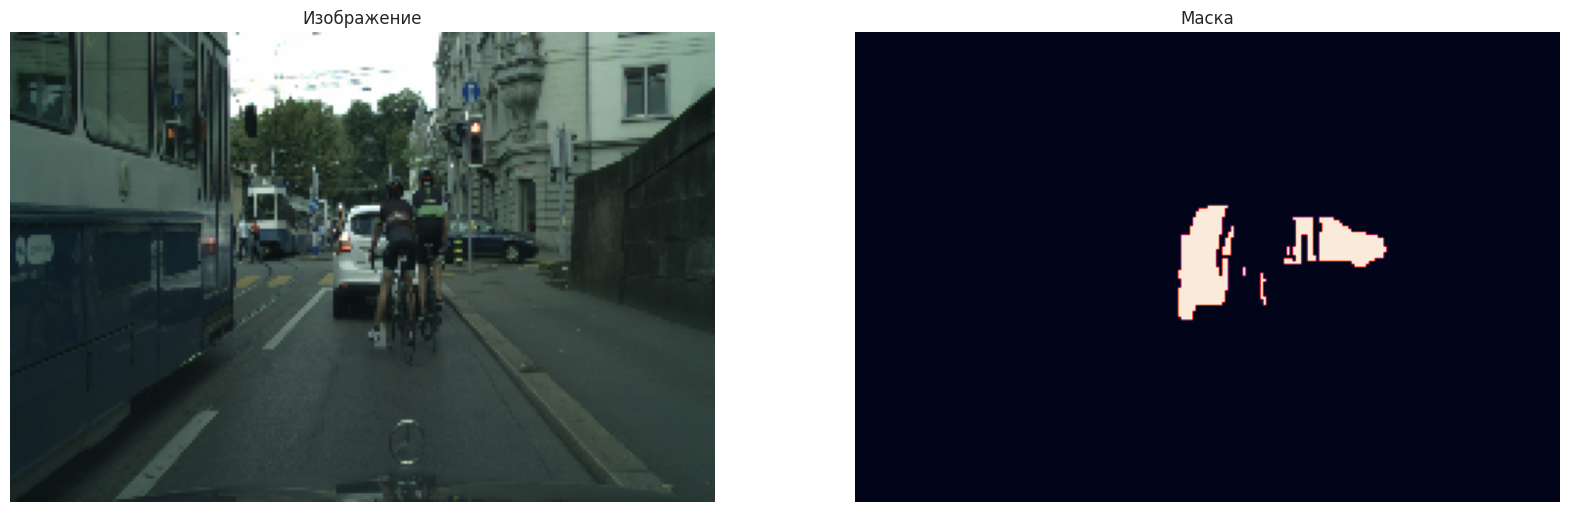

In [ ]:
plot_image_mask(unnormalize(np.moveaxis(image, 0, 2)), mask[0])

Определим класс модуля lightning для обучения модели сегментации машин. В качестве моделей будем использовать предобученные `fcn_resnet50` и `deeplabv3_resnet50` из `torchvision.models.segmentation`. Особенностью их использования является то, что модели дают на выходе маски для 21 класса (как в COCO) в поле `out` (см. примеры в семинаре). В остальном модели не отличаются от тех, что мы использовали ранее.

Наша цель - сравнить работу 3 лоссов - Binary Cross Entropy, Dice Loss, Tversky Loss. Реализацию двух последних можно взять из библиотеки [monai](https://docs.monai.io/en/stable/losses.html).

В качестве метрики будем использовать IoU.

In [ ]:
def IoU(output, target, threshold=0.5, epsilon=1e-8, average='mean'):
    '''Считает IOU по output, target
    * threshold : параметр IoU
    * epsilon : добавка для числ. стабильности
    * average : mean -> вернет среднее, None -> вернет BS значений'''
    TP = ((output >= threshold) & (target >= threshold)).sum(axis=(2, 3))
    FP = ((output >= threshold) & (target < threshold)).sum(axis=(2, 3))
    FN = ((output < threshold) & (target >= threshold)).sum(axis=(2, 3))
    iou = TP / (TP + FP + FN + epsilon)
    if average == 'mean':
        return iou.mean()
    elif average is None:
        return iou.flatten()
    else:
        raise NotImplementedError

Определим lightning модуль.

In [ ]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, model, criterion=nn.BCELoss(), lr=1e-3, monai=False):
        '''Модуль для сегментации машин
        * criterion -- лосс
        * lr -- learning rate
        * monai -- True если criterion из библиотеки monai'''

        super().__init__()
        self.lr = lr
        self.criterion = criterion
        self.model = model(weights='DEFAULT')
        self.metric = IoU
        self.monai = monai

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def __step(self, batch, name):
        ''' Описывает 1 шаг обучения на batch
        * name -- либо train, либо val'''
        images, target = batch
        logits = self.forward(images)['out']
        if self.monai:
            car_logits = logits[:, 7]
            non_car_logits = torch.sum(logits[:, :7], dim=1) + torch.sum(logits[:, 8:], dim=1)
            all_logits = torch.stack([non_car_logits, car_logits], dim=1)
            preds = torch.softmax(all_logits, dim=1)
        else:
            preds = torch.softmax(logits, dim=1)[:, 7].unsqueeze(1)
        loss = self.criterion(preds, target)
        preds = torch.softmax(logits, dim=1)[:, 7].unsqueeze(1)
        iou = self.metric(preds, target)
        self.log(name+'_loss', loss)
        self.log(name+'_iou', iou)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, 'val')

In [ ]:
model_fcn_BCE = SegmentationModel(models.segmentation.fcn_resnet50)
model_dlv3_BCE = SegmentationModel(models.segmentation.deeplabv3_resnet50)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:03<00:00, 41.2MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 90.0MB/s]


#### Визуализация до обучения

До обучения визуализируем несколько предсказаний FCN и DeepLabV3 из torchvision на тестовой части CityScapes.

Заметим, что нам нужен 7 канал выхода модели, который соответствует классу 'car'.

In [ ]:
def visualize_preds(model, other_model, model_names):
    '''Визуализация предсказаний 2 моделей для сравнения
    * model -- первая модель
    * other_model -- вторая модель
    * model_names -- названия моделей'''
    np.random.seed(42)
    idx = np.random.choice(np.arange(len(test_set)), 8)
    images = [test_set[i][0] for i in idx]

    image_batch = torch.from_numpy(np.stack(images))

    model.eval()
    other_model.eval()
    with torch.no_grad():
        pred_batch = torch.softmax(model(image_batch)['out'], dim=1)[:, 7].unsqueeze(1)
        pred_batch_other = torch.softmax(other_model(image_batch)['out'], dim=1)[:, 7].unsqueeze(1)

    masks = [test_set[i][1] for i in idx]
    fig, axs = plt.subplots(8, 4, figsize=(11, 17))
    axs[0][1].set_title(model_names[0])
    axs[0][2].set_title(model_names[1])
    axs[0][3].set_title('Истина')
    axs[0][0].set_title('Исходное изобр.')

    for i in range(8):
        image, pred = image_batch[i].numpy(), pred_batch[i][0].numpy()
        image = unnormalize(np.moveaxis(image, 0, 2))
        axs[i][0].imshow(image)
        axs[i][0].axis("off")
        axs[i][1].imshow(pred)
        axs[i][1].axis("off")

        pred = pred_batch_other[i][0].numpy()
        axs[i][2].imshow(pred)
        axs[i][2].axis("off")
        axs[i][3].imshow(unnormalize(np.moveaxis(masks[i], 0, 2)))
        axs[i][3].axis("off")

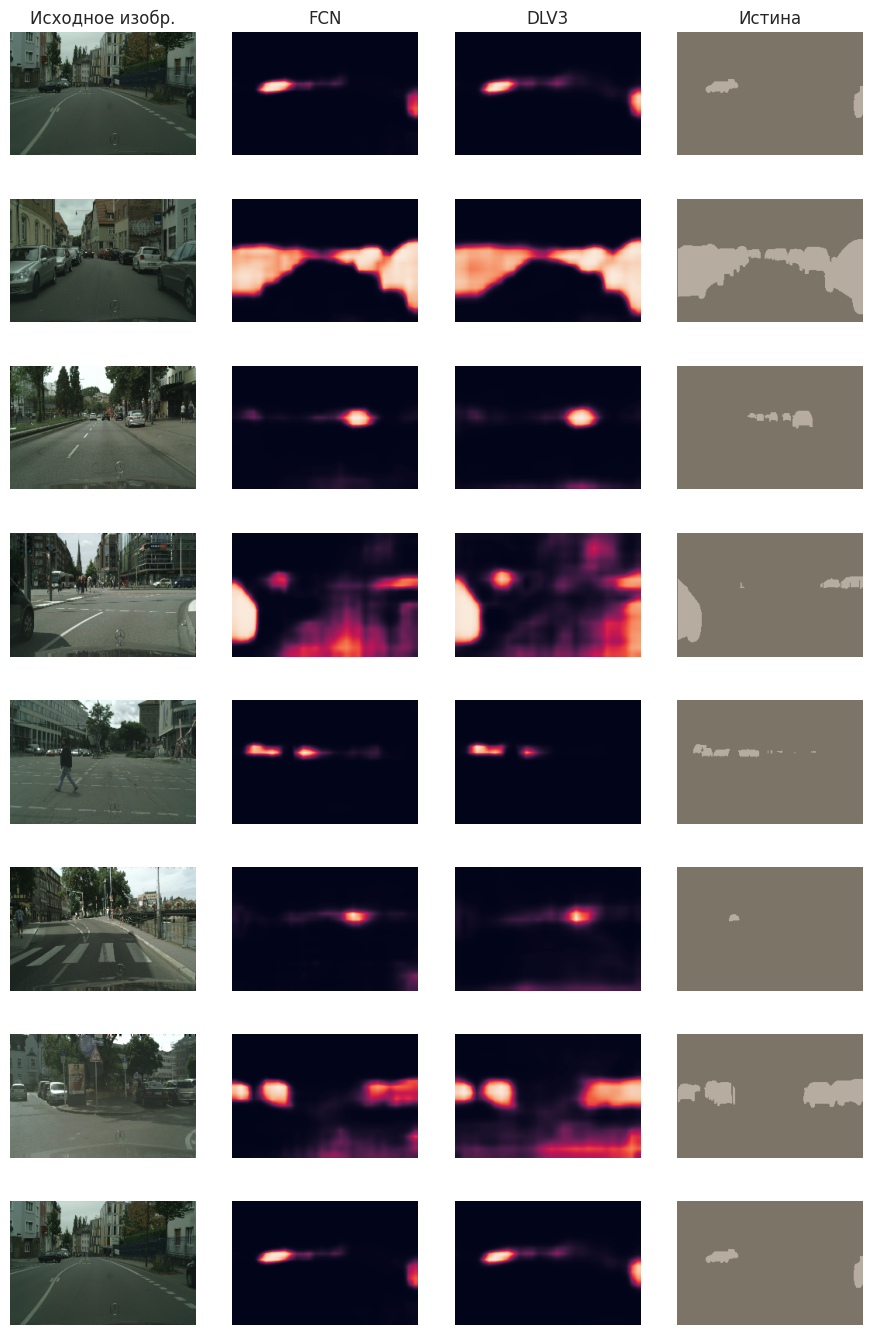

In [ ]:
visualize_preds(model_fcn_BCE, model_dlv3_BCE, ['FCN', 'DLV3'])

Предсказания моделей похожи, и сложно определить, какая лучше.

#### Binary Cross Entropy

Обучим предобученные FCN и DeepLabV3, используя BCE Loss. Сравним несколько предсказаний 2 моделей с истинными масками на тестовой выборке.

Обучим FCN.

In [ ]:
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_iou', mode='max')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_fcn_BCE, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | criterion | BCELoss | 0     
1 | model     | FCN     | 35.3 M
--------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_fcn_BCE, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │     0.438331663608551     │
│         val_loss          │    0.08134873956441879    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.08134873956441879, 'val_iou': 0.438331663608551}]

Обучим DeepLabV3.

In [ ]:
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_dlv3_BCE, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory ./Segmentation/ap6daspw/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | criterion | BCELoss   | 0     
1 | model     | DeepLabV3 | 42.0 M
----------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
168.016   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_dlv3_BCE, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.5273475050926208     │
│         val_loss          │   0.042945001274347305    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.042945001274347305, 'val_iou': 0.5273475050926208}]

IoU у DeepLabV3 получилось больше. Посмотрим на визуализацию.

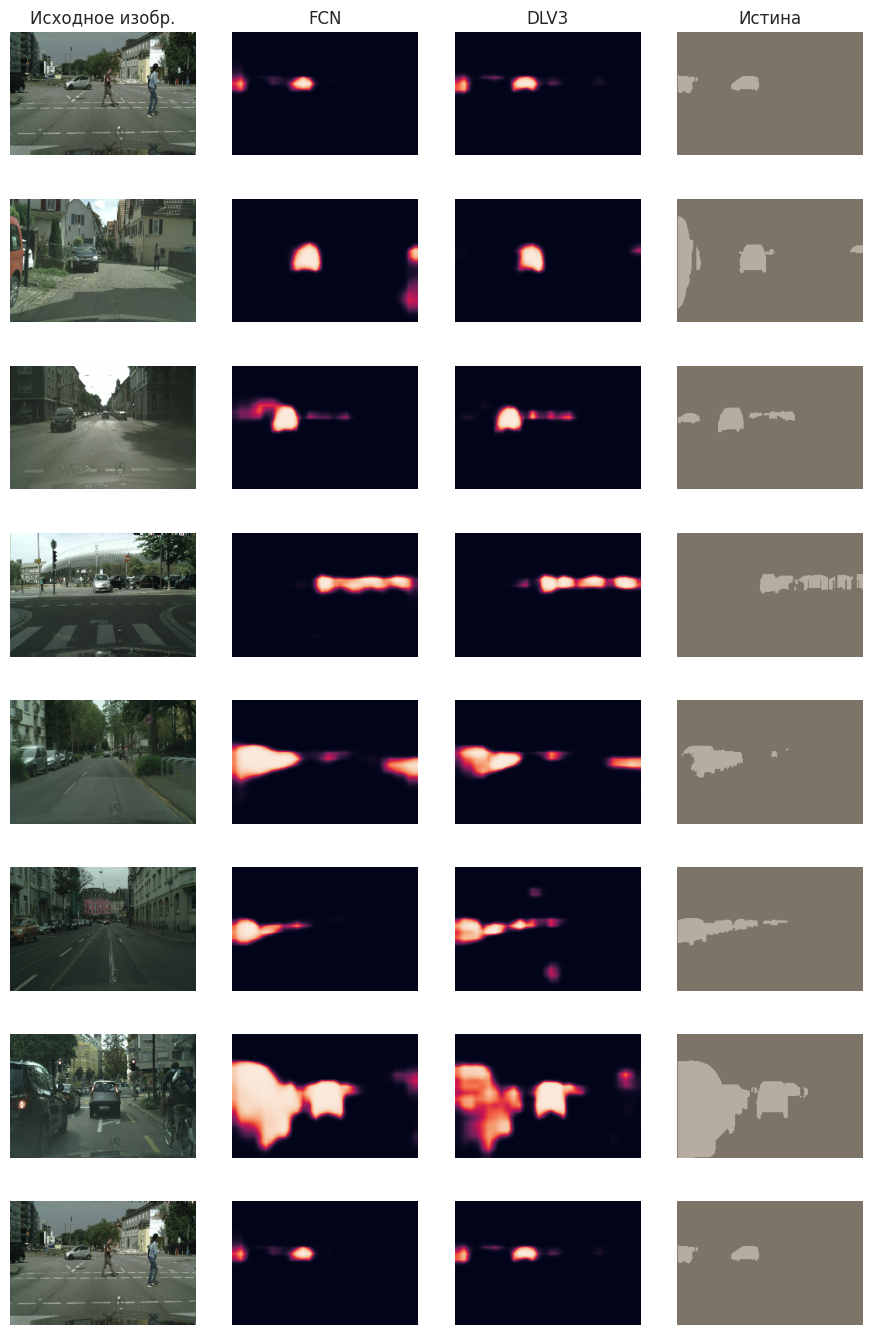

In [ ]:
visualize_preds(model_fcn_BCE, model_dlv3_BCE, ['FCN', 'DLV3'])

#### Dice Loss

Сделайте то же самое для Dice Loss.

Обучим FCN.

In [ ]:
model_fcn_Dice = SegmentationModel(models.segmentation.fcn_resnet50,
                                   criterion=DiceLoss(to_onehot_y=True, include_background=False),
                                   monai=True)
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_fcn_Dice, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | criterion | DiceLoss | 0     
1 | model     | FCN      | 35.3 M
---------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_fcn_Dice, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.3360193967819214     │
│         val_loss          │    0.3606623113155365     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3606623113155365, 'val_iou': 0.3360193967819214}]

Обучим DeepLabV3.

In [ ]:
model_dlv3_Dice = SegmentationModel(models.segmentation.deeplabv3_resnet50,
                                    criterion=DiceLoss(to_onehot_y=True, include_background=False),
                                    monai=True)
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_dlv3_Dice, train_loader, test_loader)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 88.6MB/s]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory ./Segmentation/udan8ye2/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | criterion | DiceLoss  | 0     
1 | model     | DeepLabV3 | 42.0 M
----------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
168.016   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_dlv3_Dice, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.3265244662761688     │
│         val_loss          │    0.34260299801826477    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.34260299801826477, 'val_iou': 0.3265244662761688}]

IoU в обоих случаях хуже, при этом теперь FCN лучше DeepLabV3.

Судя по визуализации, чего больше у моделей - False Negative или False Positive предсказаний?

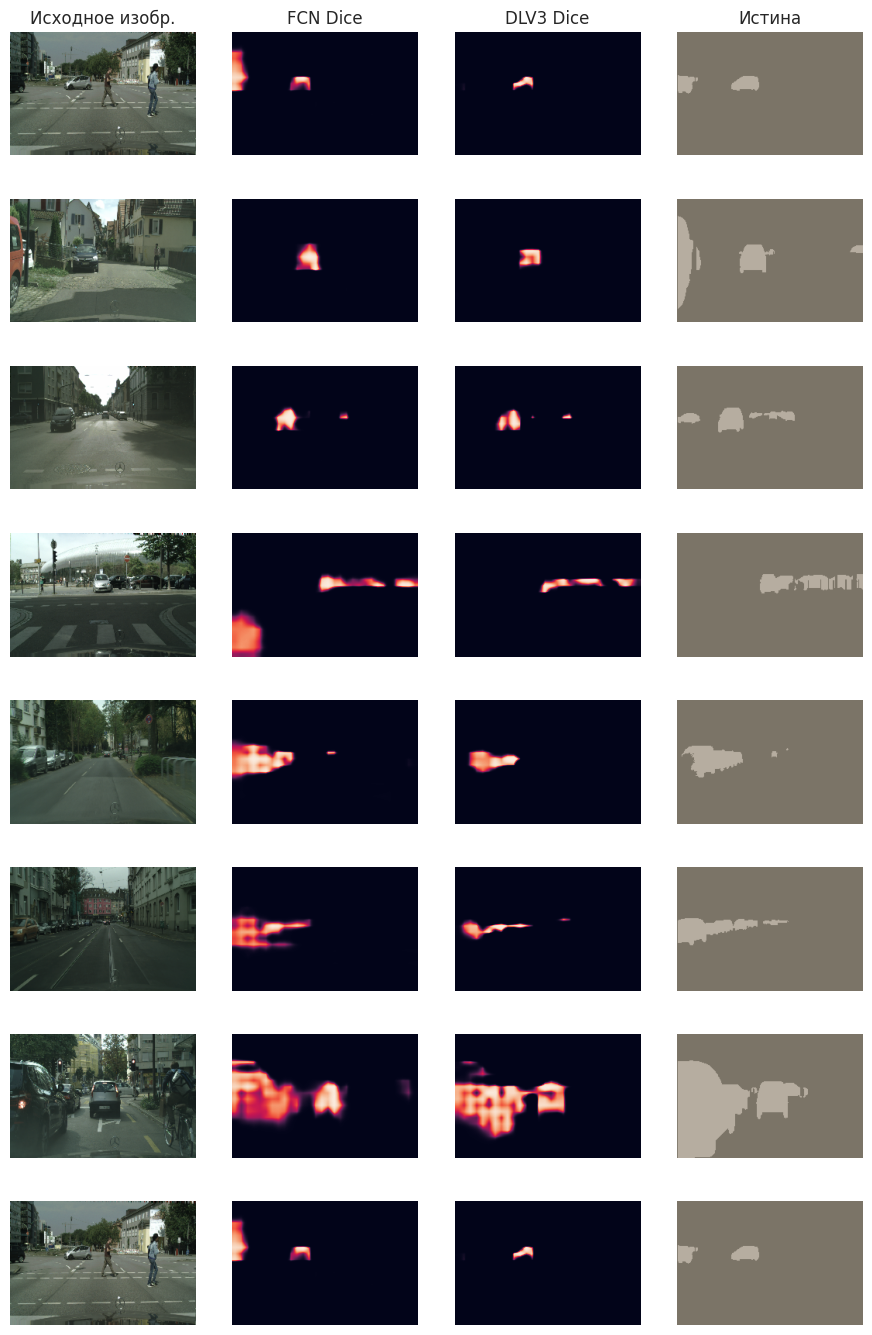

In [ ]:
visualize_preds(model_fcn_Dice, model_dlv3_Dice, ['FCN Dice', 'DLV3 Dice'])

Здесь явно видно, что FCN как будто предсказывает лишнее (больше FP), а DeepLabV3 наоборот недопредсказывает (больше FN).

#### Tversky Loss

Tversky Index является обобщением Dice Index для произвольных весов при FP и FN:

$$T_{\alpha, \beta} (y, \hat{y}) = \frac{\text{TP}}{\text{TP} + \alpha \ \text{FP} + \beta \ \text{FN}}$$

При этом $T_{\frac{1}{2}, \frac{1}{2}} –$ Dice Index; а $T_{1, 1} - $ Jaccard index (IoU).

Исходя из выводов про FN и FP подберите параметры $\alpha, \beta$ у Tversky Loss для обеих моделей. Обучите их с таким лоссом. Улучшилась ли метрика? Как изменились предсказания визуально?

Обучим FCN с большой $\alpha$.

In [ ]:
model_fcn_Tversky = SegmentationModel(models.segmentation.fcn_resnet50,
                                      criterion=TverskyLoss(to_onehot_y=True, include_background=False, alpha=0.7, beta=0.3),
                                      monai=True)
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_fcn_Tversky, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory ./Segmentation/udan8ye2/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | criterion | Tvers

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_fcn_Tversky, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.3520760238170624     │
│         val_loss          │     0.382120281457901     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.382120281457901, 'val_iou': 0.3520760238170624}]

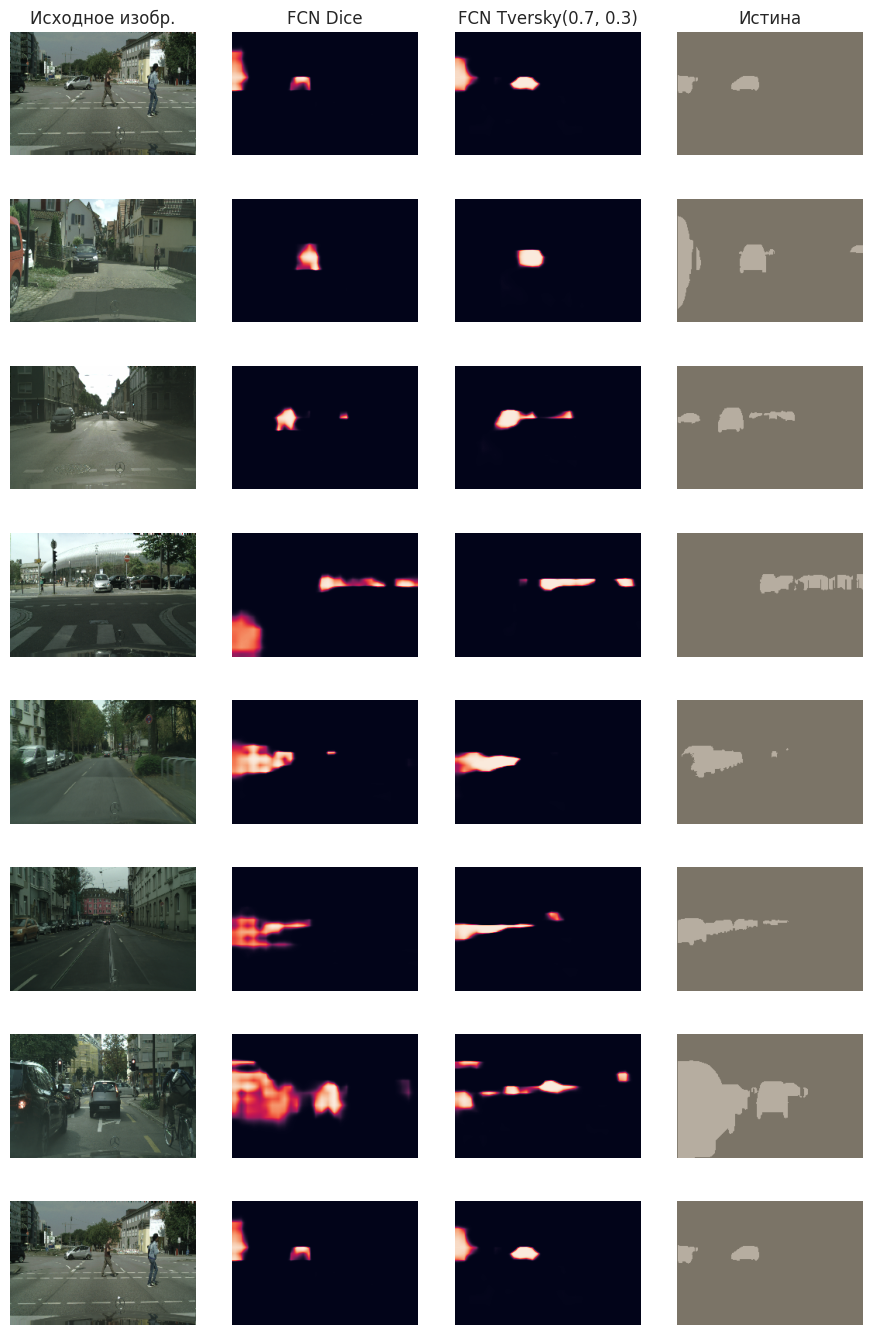

In [ ]:
visualize_preds(model_fcn_Dice, model_fcn_Tversky, ['FCN Dice', 'FCN Tversky(0.7, 0.3)'])

FCN теперь предсказывает меньше лишнего.

Обучим DeepLabV3 с большой $\beta$.

In [ ]:
model_dlv3_Tversky = SegmentationModel(models.segmentation.deeplabv3_resnet50,
                                       criterion=TverskyLoss(to_onehot_y=True, include_background=False, alpha=0.3, beta=0.7),
                                      monai=True)
wandb.init(project='Segmentation')
wandb_logger = WandbLogger(project='Segmentation', log_model='all')
trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=10, log_every_n_steps=1,
    callbacks=[checkpoint_callback])
trainer.fit(model_dlv3_Tversky, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | criterion | TverskyLoss | 0     
1 | model     | DeepLabV3   | 42.0 M
------------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
168.016   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model_dlv3_Tversky, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.33448392152786255    │
│         val_loss          │    0.5459712147712708     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5459712147712708, 'val_iou': 0.33448392152786255}]

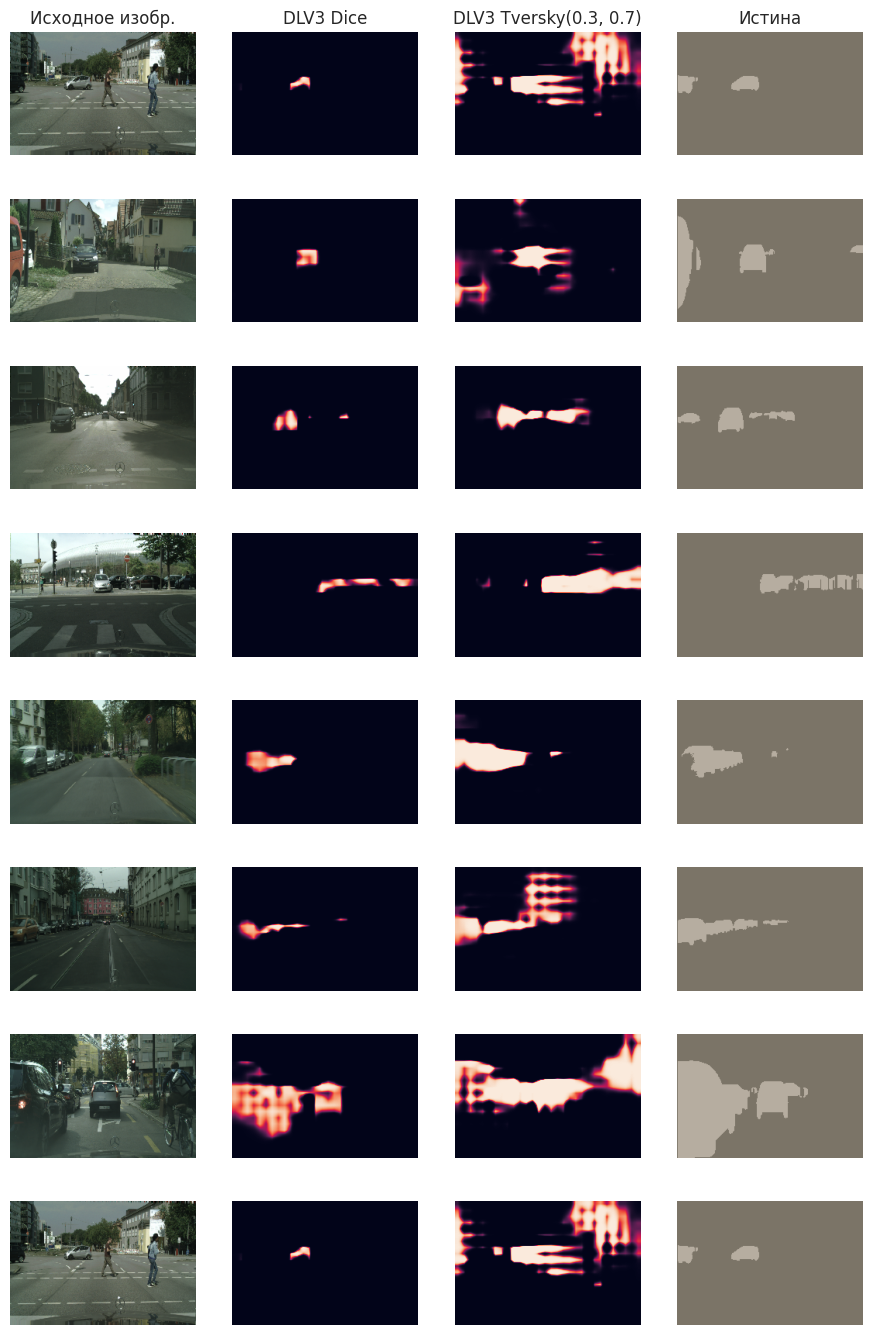

In [ ]:
visualize_preds(model_dlv3_Dice, model_dlv3_Tversky, ['DLV3 Dice', 'DLV3 Tversky(0.3, 0.7)'])

DeepLabV3 теперь предсказывает больше, но, кажется, мы перестарались.

#### Визуализация логов обучения

Визуализируем лосс и метрику на обучении и валидации на предыдущих запусках.

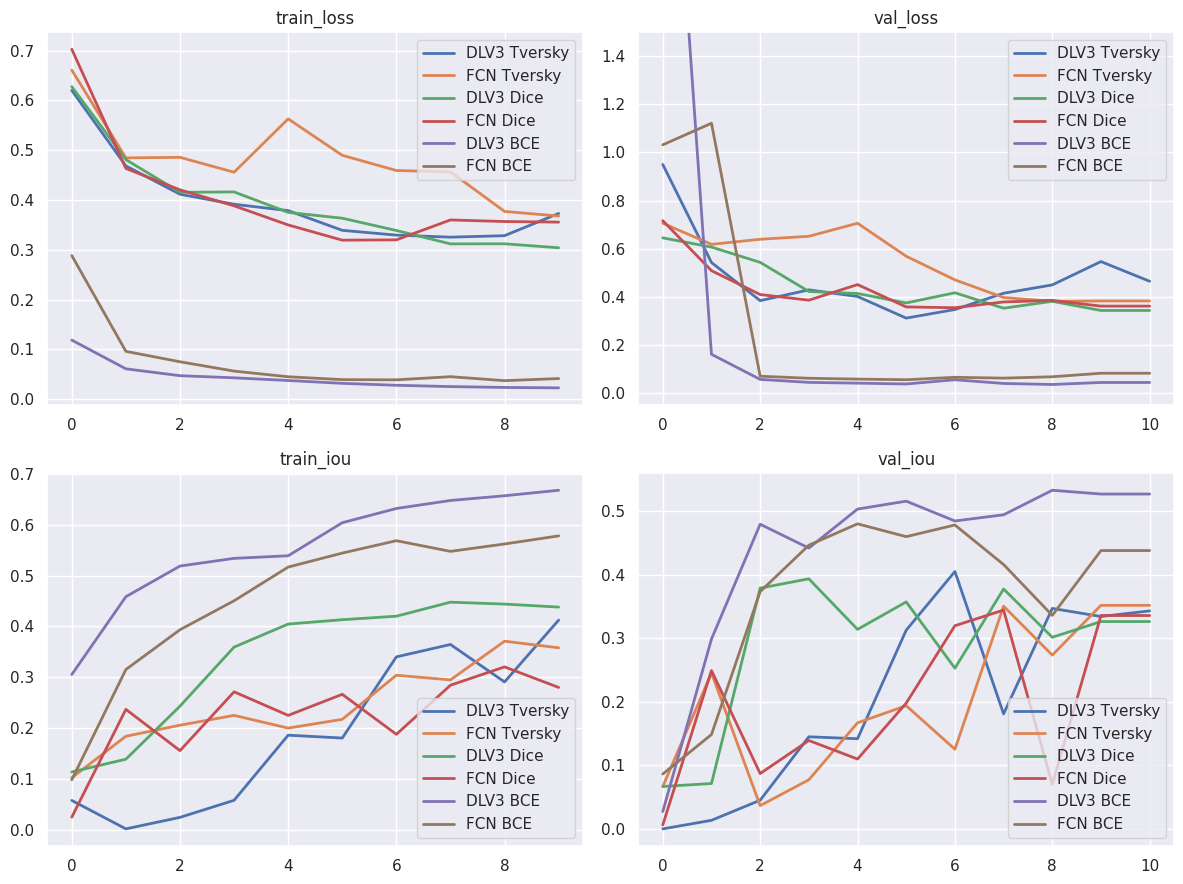

In [ ]:
runs = list(wandb.Api().runs("Segmentation"))
subplot_names = np.array([['train_loss', 'val_loss'],
                    ['train_iou', 'val_iou']])

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs[:-1]):
df = run.history().groupby('epoch').mean(numeric_only=True)
for k in range(2):
    for m in range(2):
        axs[k, m].set_title(subplot_names[k, m])
        axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
        axs[k, m].legend()
axs[0, 1].set_ylim(-0.05, 1.5)

**Выводы:** BCE Loss выиграл по IoU и на train, и на валидации, причем DeepLabV3 имел значительный отрыв. При обучении с Dice Loss модели почти не отличались по IoU на валидации, но при этом после подбора $\alpha, \beta$ в TverskyLoss для обеих моделей IoU немного повысилось. Визуально предсказания изменились так, как мы ожидали: у FCN с повышенным $\alpha$ стало меньше предсказаний машин, у DeepLabV3 с повышенным $\beta$ – больше.